# Appendix __________________ - Supporting Python Code

#### Steve Desilets

#### October 10, 2023

## 1) Introduction

In this assignment, we will leverage the CIFAR-10 dataset train convolutional neural network (CNN) and deep neural network (DNN) models. 

The CIFAR-10 dataset contains 60,000 training and 10,000 testing images that correspond to one of 10 categories: 
1. Airplane
2. Automobile
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck


We will aim to build the most accurate model possible and will examine the utility of the features extracted by each of these models during training.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

### 1.1) Notebook Set-Up

Let's begin by importing the relevant packages.

In [221]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [222]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

Let's verify the version of Tensorflow.

In [223]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


Let's mount to the Google Colab environment.

In [224]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

Let's define functions that we can leverage for exploratory data analysis and for reporting.

In [225]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [226]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

In [227]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [228]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [229]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### 1.2) Exploratory Data Analysis and Data Pre-processing

#### Loading the CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [230]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Let's conduct Exploratory Data Analysis on the imported data.

In [231]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [232]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


Let's plot a subset of example images from this imported dataset.

In [233]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [234]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

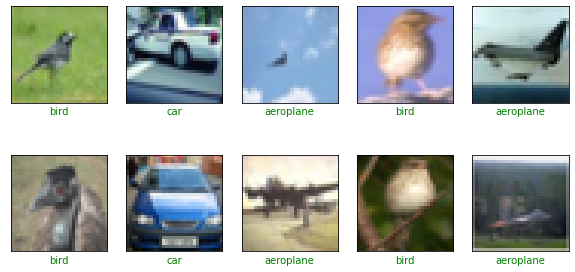

In [235]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

Let's preprocess the data prior to model development.

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [236]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

Let's create a validation dataset.

In [237]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [238]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


Let's rescale the data.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [239]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [240]:
y_train_split.shape

(45000, 1)

## 2) Model 1 - Deep Neural Network with 2 Hidden Layers and No Regularization 

### 2.1) Conduct Data Preprocessing For the Model

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 3D arrays of shape (32, 32, 3) to 1D *float32* arrays of shape (3072,).

##### Let's apply one-hot coding to the labels.

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [48]:
y_train_encoded = to_categorical(y_train_split)
y_valid_encoded = to_categorical(y_valid_split)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train_split:\n {}\n".format(y_train_split[0:10]))
print("First ten rows of one-hot y_train_encoded:\n {}".format(y_train_encoded[0:10,]))

print("First ten entries of y_valid_split:\n {}\n".format(y_valid_split[0:10]))
print("First ten rows of one-hot y_valid_encoded:\n {}".format(y_valid_encoded[0:10,]))

print("First ten entries of y_test:\n {}\n".format(y_test[0:10]))
print("First ten rows of one-hot y_test_encoded:\n {}".format(y_test_encoded[0:10,]))

First ten entries of y_train_split:
 [[3]
 [1]
 [0]
 [3]
 [2]
 [4]
 [5]
 [9]
 [1]
 [5]]

First ten rows of one-hot y_train_encoded:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
First ten entries of y_valid_split:
 [[7]
 [8]
 [0]
 [6]
 [1]
 [6]
 [8]
 [0]
 [6]
 [5]]

First ten rows of one-hot y_valid_encoded:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
First ten entries of y_test:
 [[3]
 [8]
 [8]
 [0]
 [6]
 [6]
 [1]
 [6]
 [

In [49]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_valid_encoded shape:', y_valid_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (45000, 10)
y_valid_encoded shape: (5000, 10)
y_test_encoded shape:  (10000, 10)


Reshape the images from shape (32, 32, 3) 2D arrays to shape (3072, ) vectors (1D arrays).

In [39]:
# Before reshape:
print('x_train_norm:\t{}'.format(x_train_norm.shape))
print('x_valid_norm:\t{}'.format(x_valid_norm.shape))
print('x_test_norm:\t\t{}'.format(x_test_norm.shape))

x_train_norm:	(45000, 32, 32, 3)
x_valid_norm:	(5000, 32, 32, 3)
x_test_norm:		(10000, 32, 32, 3)


In [42]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train_norm, (45000, 3072))
x_valid_reshaped = np.reshape(x_valid_norm, (5000, 3072))
x_test_reshaped = np.reshape(x_test_norm, (10000, 3072))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_valid_reshaped shape: ', x_valid_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (45000, 3072)
x_valid_reshaped shape:  (5000, 3072)
x_test_reshaped shape:  (10000, 3072)


### 2.2) Build The Model

In [50]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[3072], units=256, activation = tf.nn.relu),
    Dense(units=64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 803,786
Trainable params: 803,786
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [53]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_reshaped
    ,y_train_encoded
    ,epochs = 200
    ,validation_data=(x_valid_reshaped, y_valid_encoded)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )


Epoch 1/200
1407/1407 [==============================] - 15s 10ms/step - loss: 1.9504 - accuracy: 0.2983 - val_loss: 1.8590 - val_accuracy: 0.3300
Epoch 2/200
1407/1407 [==============================] - 12s 8ms/step - loss: 1.7446 - accuracy: 0.3740 - val_loss: 1.7444 - val_accuracy: 0.3682
Epoch 3/200
1407/1407 [==============================] - 12s 9ms/step - loss: 1.6752 - accuracy: 0.4031 - val_loss: 1.7509 - val_accuracy: 0.3776
Epoch 4/200
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6218 - accuracy: 0.4228 - val_loss: 1.7226 - val_accuracy: 0.3890
Epoch 5/200
1407/1407 [==============================] - 12s 8ms/step - loss: 1.5863 - accuracy: 0.4381 - val_loss: 1.6360 - val_accuracy: 0.4114
Epoch 6/200
1407/1407 [==============================] - 12s 8ms/step - loss: 1.5593 - accuracy: 0.4482 - val_loss: 1.6533 - val_accuracy: 0.4110
Epoch 7/200
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5360 - accuracy: 0.4561 - val_loss: 1.5470 

### 2.2) Evaluate Model Performance

Now that we've fit our model, let's apply the model to the test dataset and subsequently evaluate its performance.

In [55]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_reshaped, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5188 - accuracy: 0.4648
Test acc: 0.465


In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [56]:
preds = model.predict(x_test_reshaped)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 2ms/step
shape of preds:  (10000, 10)


As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

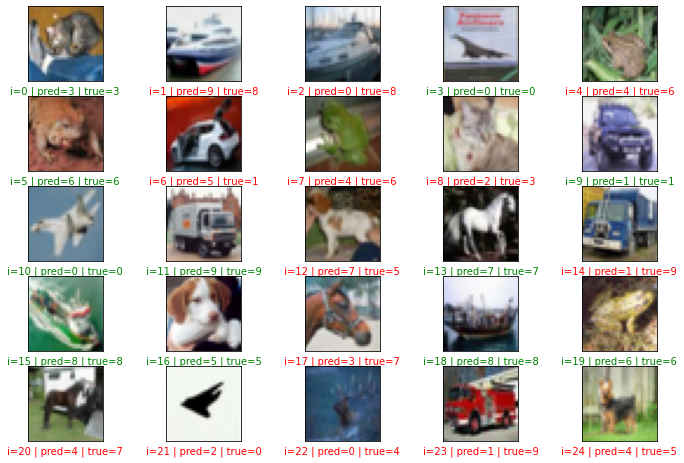

In [57]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,1.586,0.438,1.636,0.411
5,1.559,0.448,1.653,0.411
6,1.536,0.456,1.547,0.451
7,1.522,0.459,1.590,0.445
8,1.510,0.466,1.599,0.425


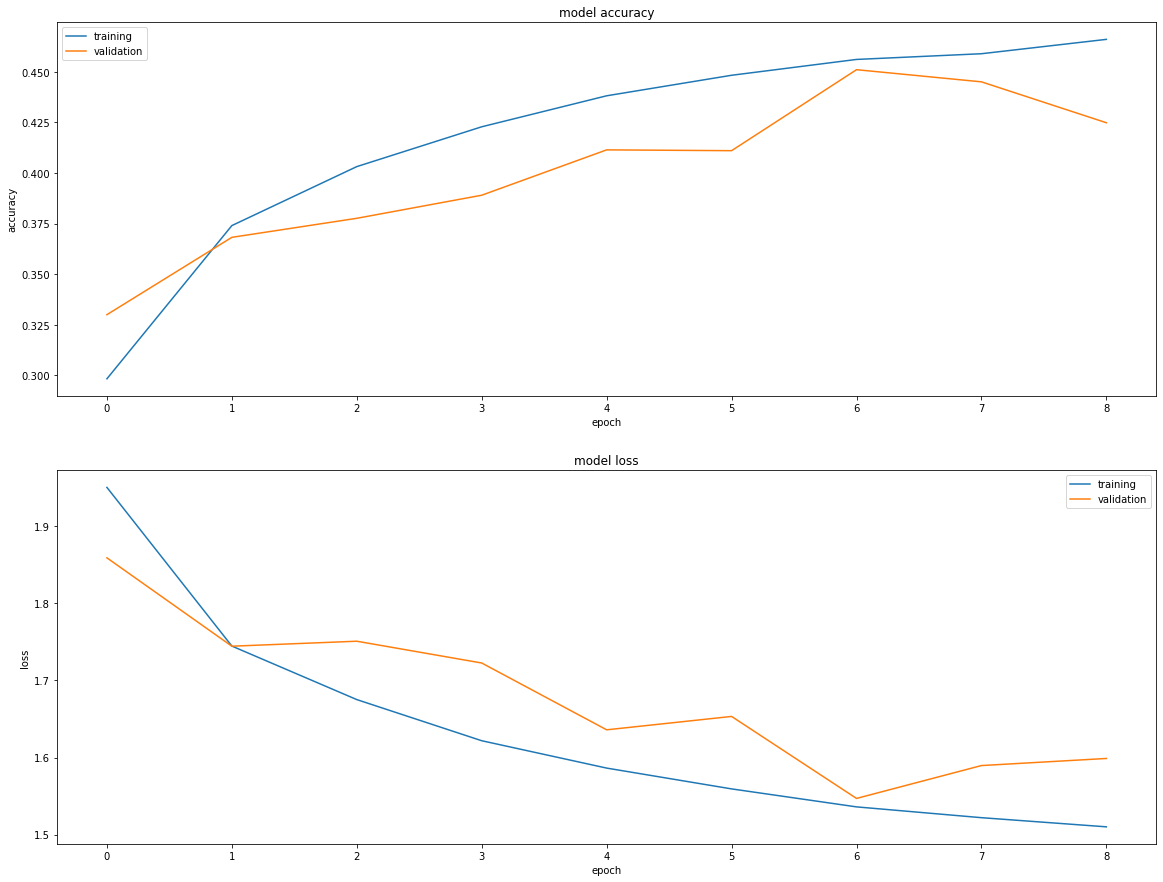

In [60]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
######################## MAYBE DISTRUST THIS CODE LOL ##############################################################

Let's examine precision and recall performance metrics for each of the prediction classes.

In [62]:
pred1= model.predict(x_test_reshaped)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 2ms/step


In [64]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.63      0.52      1000
           1       0.60      0.59      0.59      1000
           2       0.37      0.26      0.30      1000
           3       0.31      0.31      0.31      1000
           4       0.41      0.44      0.43      1000
           5       0.43      0.28      0.34      1000
           6       0.44      0.59      0.50      1000
           7       0.50      0.54      0.52      1000
           8       0.60      0.53      0.56      1000
           9       0.55      0.49      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000
weighted avg       0.46      0.46      0.46     10000

Accuracy Score: 0.4648
Root Mean Square Error: 3.211930883440676


Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

In [65]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_reshaped), axis=-1)
pred_classes;

313/313 [==============================] - 1s 2ms/step


<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [66]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [67]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,6.22%,1.40%,5.46%,27.08%,6.85%,14.16%,18.82%,1.17%,17.92%,0.93%
1,6.52%,20.25%,0.61%,0.64%,0.38%,0.08%,0.05%,0.56%,22.93%,47.98%
2,39.94%,8.45%,1.25%,0.48%,0.87%,0.20%,0.03%,1.67%,16.51%,30.59%
3,29.96%,1.95%,12.50%,3.28%,10.06%,2.48%,0.13%,22.71%,14.14%,2.78%
4,0.40%,0.08%,6.94%,2.23%,69.12%,3.29%,16.49%,1.21%,0.20%,0.04%
5,2.08%,1.26%,5.79%,17.32%,6.68%,8.65%,51.82%,4.45%,0.42%,1.53%
6,2.20%,5.73%,8.68%,22.83%,2.28%,44.08%,6.87%,1.61%,0.80%,4.92%
7,1.84%,0.85%,14.57%,4.65%,33.12%,4.24%,21.97%,18.03%,0.37%,0.36%
8,6.80%,0.64%,27.82%,16.21%,11.36%,16.72%,6.17%,13.13%,0.83%,0.32%
9,2.16%,66.92%,1.72%,2.34%,0.50%,0.30%,0.12%,0.35%,4.96%,20.62%


Let's create a confusion matrix that visualizes the model's performance on the testing data.

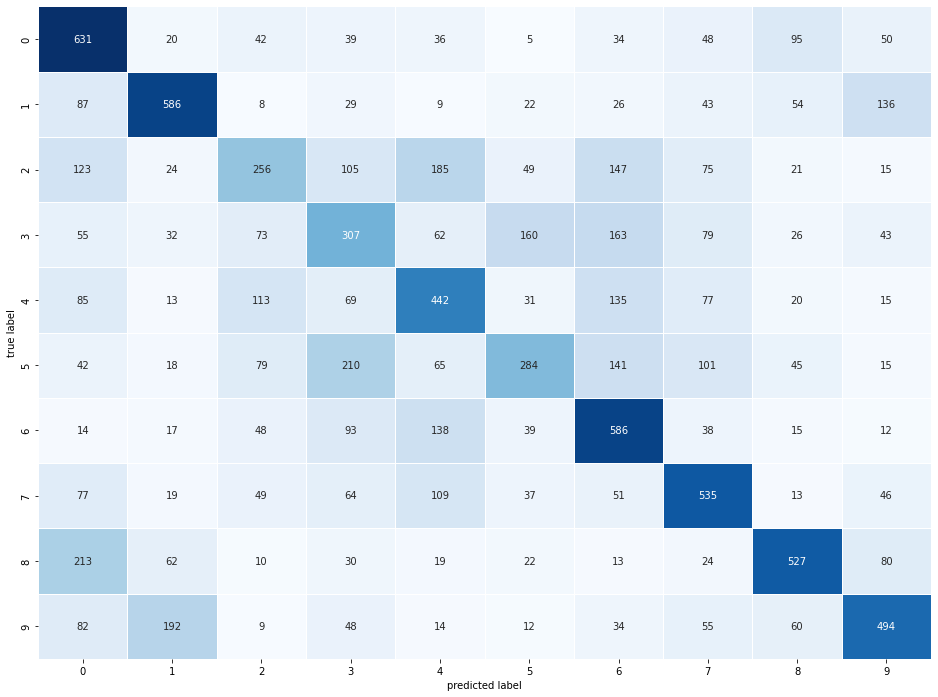

In [68]:
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
############################## SHOULD PROBABLY ADD T-SNE ###############################################

Create a T-SNE Plot

In [159]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 3 layers


In [160]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_reshaped)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the hidden nodes has one activation value per training image

1407/1407 [==============================] - 4s 2ms/step


(45000, 256)

In [161]:
output_layer_activations.shape

(45000, 64)

In [162]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 74.5993423461914


In [179]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (45000, 64)
The output for the first image are [0.    0.    0.    1.437 0.    0.    0.    4.802 0.    0.    0.    2.312 0.    0.    0.    0.075 0.    0.    4.315 0.    0.168 0.    0.    1.724 1.153 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    2.514 0.    1.85  0.    0.    0.034 0.    0.    0.    3.966 1.69  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.371 0.    0.    1.307]
The sum of the probabilities is (approximately) 27.718250274658203


In [164]:
y_train_tnse = []

for i in y_train:
    y_train_tsne.append(i[0])
    

In [165]:
print(type(activation_data))

<class 'dict'>


In [189]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train_tsne}

In [190]:

for k in range(0,10):
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]


In [194]:
for i in activation_data:
    print(i)


actual_class
act_val_0
act_val_1
act_val_2
act_val_3
act_val_4
act_val_5
act_val_6
act_val_7
act_val_8
act_val_9


In [197]:
print(len(y_train_tsne))

200000


In [186]:

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

ValueError: All arrays must be of the same length

In [198]:
activation_df.shape

(10000, 64)

In [199]:
N=60000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(10000, 64)

In [202]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=1
            ,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(activation_df_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...


AttributeError: 'NoneType' object has no attribute 'split'

In [201]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

NameError: name 'tsne_results' is not defined

In [74]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_valid_split[:2000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

NameError: name 'tsne_results' is not defined

<Figure size 1152x720 with 0 Axes>

In [111]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:2000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

ValueError: in user code:

    File "C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\steve\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\steve\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\steve\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 3072), found shape=(None, 32, 32, 3)


In [ ]:
################################################################################################

In [151]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger

feat_extractor = models.Model(inputs=model.input,
                       outputs=model.get_layer(index = -2).output)
activated_values = feat_extractor.predict(x_test_reshaped, batch_size=100)

100/100 [==============================] - 1s 3ms/step


In [152]:
tsne_column_names = []

for i in range(64):
    tsne_column_names.append(f"act_val_{i}")

In [153]:


activation_df = pd.DataFrame(activated_values, columns = tsne_column_names)

activation_df

,act_val_0,act_val_1,act_val_2,act_val_3,act_val_4,act_val_5,act_val_6,act_val_7,act_val_8,act_val_9,...,act_val_54,act_val_55,act_val_56,act_val_57,act_val_58,act_val_59,act_val_60,act_val_61,act_val_62,act_val_63
0,0.000000,1.850667,0.0,0.000000,0.000000,0.0,0.514050,3.499302,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,1.267022,0.000000,0.0,0.427308,2.451197,0.0,0.000000,...,0.0,2.955689,1.963794,0.000000,0.0,0.0,0.000000,0.0,1.691183,0.000000
2,0.269709,0.422602,0.0,2.509773,0.000000,0.0,2.073971,4.369932,0.0,0.000000,...,0.0,4.620683,3.785104,0.000000,0.0,0.0,0.000000,0.0,0.639554,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,2.545274,4.293341,0.0,0.000000,...,0.0,2.457840,2.274583,0.000000,0.0,0.0,0.000000,0.0,1.789442,0.000000
4,2.377550,1.614083,0.0,0.000000,0.993432,0.0,0.815206,1.427574,0.0,0.000000,...,0.0,0.000000,2.288483,0.067114,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.417624,1.839458,0.0,0.000000,0.000000,0.0,0.969296,9.179074,0.0,0.000000,...,0.0,4.312600,0.813961,0.000000,0.0,0.0,0.000000,0.0,1.522755,0.708908
9996,1.000752,0.195727,0.0,0.000000,0.000000,0.0,0.000000,2.996121,0.0,0.706355,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.770185,0.0,0.000000,0.733019
9997,1.576247,0.000000,0.0,0.000000,0.526517,0.0,1.791956,6.191132,0.0,1.053867,...,0.0,2.738608,1.590572,0.000000,0.0,0.0,2.107616,0.0,0.629445,0.000000
9998,0.522489,3.153857,0.0,0.000000,1.797266,0.0,1.191647,2.739393,0.0,0.348940,...,0.0,1.322828,2.916904,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [154]:
activation_df.shape

(10000, 64)

In [155]:
N=10000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(10000, 64)

In [158]:
features

[array([0.   , 0.   , 0.   , 1.267, 0.   , 0.   , 0.427, 2.451, 0.   , 0.   , 0.   , 0.307, 0.   , 0.   , 0.   , 5.503, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 6.431, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.049, 2.347, 2.353, 0.   , 0.681, 0.   , 0.   , 0.282, 0.   , 0.   , 2.956, 1.964, 0.   , 0.   , 0.   , 0.   , 0.   , 1.691, 0.   ], dtype=float32),
 array([0.27 , 0.423, 0.   , 2.51 , 0.   , 0.   , 2.074, 4.37 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.488, 0.   , 3.804, 0.   , 0.   , 0.457, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.664, 3.328, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.854, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.087, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 4.621, 3.785, 0.   , 0.   , 0.   , 0.   , 0.   , 0.64 , 0.   ], dtype=float32),
 array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 2.54

In [156]:
features = [*activated_values][1:]
data_subset = activation_df_subset[features].values
data_subset.shape

KeyError: "None of [Index([                                                                 (0.0, 0.0, 0.0, 1.2670224, 0.0, 0.0, 0.42730755, 2.4511974, 0.0, 0.0, 0.0, 0.30700842, 0.0, 0.0, 0.0, 5.502538, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.4310794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04869231, 2.3467798, 2.3526978, 0.0, 0.68063647, 0.0, 0.0, 0.28176937, 0.0, 0.0, 2.9556887, 1.9637941, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6911827, 0.0),\n                                                                        (0.26970923, 0.42260188, 0.0, 2.5097733, 0.0, 0.0, 2.073971, 4.369932, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48791915, 0.0, 3.803886, 0.0, 0.0, 0.45667404, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6637881, 3.3277285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.854387, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0874758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.620683, 3.785104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6395536, 0.0),\n                                                                                                (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5452745, 4.2933407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37530544, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3362589, 0.0, 0.0, 0.2722659, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.130099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2799191, 0.0, 0.0, 1.3966684, 0.0, 0.0, 0.0, 0.0, 0.0, 2.45784, 2.2745829, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7894416, 0.0),\n                                              (2.3775504, 1.6140828, 0.0, 0.0, 0.99343246, 0.0, 0.8152055, 1.4275737, 0.0, 0.0, 2.8793552, 1.8897153, 0.0, 1.4872332, 0.0, 0.0, 0.02374658, 0.0, 0.1380199, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7621886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0249107, 0.0, 0.0, 0.84154916, 0.0, 0.0, 0.0, 2.2182832, 0.0, 0.0, 0.0, 0.11915675, 0.0, 2.4251513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2884831, 0.067113936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                                     (0.0, 0.0, 0.0, 0.88832706, 0.5780993, 0.0, 0.0, 2.4148643, 0.0, 0.0, 0.0, 1.828023, 0.0, 0.034511685, 0.0, 0.0, 1.2536887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8601122, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6052699, 0.0, 0.0, 0.0, 1.333101, 0.0, 0.0, 0.0, 0.0, 1.5032809, 0.8349091, 1.1463244, 0.0, 3.157942, 2.0238266, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19524345),\n                                                                  (0.21599759, 1.1732488, 0.0, 0.0, 0.0, 0.0, 2.0408914, 3.345808, 0.0, 0.0, 0.0, 2.0414171, 0.0, 0.0, 0.0, 1.0048492, 0.24717, 0.0, 3.4721107, 0.0, 0.61557615, 0.0, 0.0, 1.4378788, 0.0, 0.0, 0.0, 0.0, 1.0596273, 0.0, 0.2577623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.01248, 0.59336114, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2257643, 2.1706681, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                         (0.0, 0.9556446, 0.0, 0.0, 0.4000507, 0.0, 0.6989093, 0.0, 0.0, 0.0, 1.216504, 0.059110314, 0.0, 0.24374002, 0.0, 0.0, 1.0988597, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0692858, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.297927, 0.0, 0.0, 1.0672886, 0.0, 0.0, 0.0, 0.7895318, 0.0, 1.1710011, 1.681939, 0.8167473, 0.0, 2.2806897, 0.42313263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8957656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                                                         (0.0, 0.4856009, 0.0, 0.0, 0.0, 0.0, 3.3256743, 3.739285, 0.0, 0.0, 0.6302233, 1.4999864, 0.0, 0.0, 0.0, 0.0, 0.5112293, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5986872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3790774, 0.0, 0.0, 2.0412705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7064654, 1.2280096, 0.0, 4.7702827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                                 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1961806, 0.95110685, 0.0, 0.0, 0.0, 0.0, 0.1098596, 0.0, 0.0, 1.8422213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5083106, 0.0, 0.0, 0.02112472, 5.346869, 0.0, 3.0921993, 0.0, 0.0, 0.2226366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0063377246, 3.5043154, 2.1661303, 0.0, 1.6783254, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9710796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99745584, 0.0),\n                                                                                        (0.551216, 0.27155387, 0.0, 0.63853186, 0.0, 0.0, 0.0, 7.0746193, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7763197, 2.6155005, 0.0, 0.0, 0.0, 0.6384567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4356091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7043719, 1.3761386, 0.0, 0.0, 0.0, 0.0, 1.6912693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.623459, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n       ...\n                                                    (2.898423, 1.7439342, 0.0, 0.0, 0.0, 0.0, 6.266135, 0.27479202, 0.0, 0.0, 1.6824596, 2.395564, 0.0, 0.0, 1.6695962, 0.0, 0.0, 0.0, 0.93207407, 0.0, 0.0, 1.8666518, 0.0, 0.0, 0.38553736, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9032662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07844737, 0.0, 3.233236, 0.0, 0.0, 0.0, 5.934381, 0.0, 0.0, 0.5317257, 0.0, 0.0, 0.0, 1.3827233, 0.0, 5.1519003, 0.53192776),\n                                                                                           (0.0, 0.0, 0.0, 1.9404502, 0.0, 0.0, 0.0, 3.9269152, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1799058, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3609682, 0.0, 0.0, 0.0, 0.914646, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5191258, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26023516, 1.509328, 0.8064827, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.849401, 4.226262, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7801524, 0.0),\n       (2.690752, 1.4100993, 0.0, 0.39496952, 0.66466576, 0.0, 0.0, 3.7758636, 0.0, 2.2866013, 2.9523885, 2.867817, 0.0, 0.16350073, 0.64832175, 0.0, 0.0, 0.0, 4.464704, 0.0, 0.0, 0.74672073, 0.0, 0.0, 0.0, 0.0, 0.0, 0.78127575, 0.0, 0.0, 0.0, 0.0, 1.272887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7016134, 4.0205336, 0.0, 3.3026726, 0.0, 0.50090206, 0.0, 3.934902, 4.073554, 0.0, 0.0, 3.0605426, 0.0, 0.0, 0.0, 1.3549495, 0.0, 0.0, 1.4546978, 0.0, 0.036205485, 1.4765333),\n                                                                      (0.5684176, 2.0602388, 0.0, 1.2547871, 0.0, 0.0, 0.0, 6.364471, 0.0, 0.0, 0.0, 0.65359354, 0.0, 2.1358345, 0.0, 0.0, 0.0, 0.0, 6.365309, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12039771, 0.0, 0.0, 4.028037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5166589, 0.0, 0.0, 0.10310122, 0.0, 0.0, 0.0, 3.476131, 0.0, 1.1071537, 0.55413175, 0.0, 0.0, 0.0, 0.0, 4.3566246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                         (1.3114887, 0.123251855, 0.0, 0.0, 2.7599084, 0.0, 1.283917, 5.24564, 0.0, 0.0, 0.43476227, 4.4066353, 0.0, 1.2058029, 0.0, 0.0, 0.0, 0.0, 4.9820447, 0.0, 0.0, 0.0, 0.0, 0.0, 1.873872, 0.0, 0.0, 1.7718046, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4240444, 0.0, 0.0, 0.65584415, 0.0, 0.0, 0.0, 2.5396776, 0.0, 4.2486305, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2502344, 0.74759156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                                      (4.4176245, 1.8394575, 0.0, 0.0, 0.0, 0.0, 0.9692958, 9.179074, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4108618, 1.5817451, 0.0, 0.0, 0.0, 6.2784276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7962157, 0.0, 0.0, 2.5051687, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.98485, 0.0, 0.0, 1.6181194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0733816, 0.0, 0.0, 0.0, 0.0, 0.0, 4.3126, 0.8139606, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5227554, 0.7089085),\n                                   (1.0007516, 0.19572705, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9961212, 0.0, 0.7063552, 1.7401297, 0.03408575, 0.0, 1.5551038, 0.0, 0.0, 0.431141, 0.0, 1.5113286, 0.0, 0.0, 0.0, 0.0, 0.0, 1.025991, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36532167, 0.0, 0.0, 0.0, 0.5826826, 0.0, 0.15841144, 2.0555916, 0.0, 2.1507936, 0.0, 0.32453832, 0.0, 3.1474898, 1.6030675, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.77018535, 0.0, 0.0, 0.73301935),\n           (1.5762467, 0.0, 0.0, 0.0, 0.526517, 0.0, 1.7919564, 6.1911316, 0.0, 1.053867, 0.43827632, 6.4601994, 0.0, 1.3654027, 0.0, 0.0, 1.2229679, 0.0, 4.4313884, 0.0, 0.6566695, 0.1055412, 0.0, 0.0, 1.8806942, 0.0, 0.0, 3.1697211, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1698797, 0.0, 0.0, 0.0, 5.19505, 0.0, 0.0, 2.4138887, 0.0, 0.32696953, 0.0, 1.1100422, 0.0, 3.6928568, 0.5637516, 0.0, 0.0, 0.0, 0.0, 2.7386081, 1.5905725, 0.0, 0.0, 0.0, 2.1076164, 0.0, 0.62944496, 0.0),\n                                        (0.5224892, 3.1538572, 0.0, 0.0, 1.7972665, 0.0, 1.1916468, 2.739393, 0.0, 0.34893993, 1.7937846, 2.1088128, 0.0, 1.3504469, 0.0, 1.8478417, 0.6049727, 0.0, 1.1924323, 0.0, 0.0, 0.0, 0.0, 0.6578256, 0.0, 0.0, 0.0, 1.3861381, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4704266, 0.0, 0.0, 0.0, 2.9338942, 0.0, 0.0, 2.0577123, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3836799, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3228282, 2.9169044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),\n                                                                  (0.0, 0.0, 0.0, 1.536252, 0.0, 0.0, 0.0, 2.1606045, 0.0, 0.0, 1.7446682, 1.3499423, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3706458, 0.0, 0.0, 1.3290937, 0.0, 3.4878194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42007035, 0.22356889, 0.0, 2.5872605, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46546826, 0.0, 0.0, 0.0, 2.2287748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.30164737, 0.83755344, 0.0, 0.0, 0.0, 2.2154107, 0.0, 0.0, 0.0)],\n      dtype='object', length=9999)] are in the [columns]"

In [ ]:
%%time
tsne = TSNE(n_components=2
            ,init='pca'
            ,learning_rate='auto'
            ,verbose=1
            ,perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

In [143]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(features_df)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
width = 4000
height = 3000
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                        int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * tx[idx]),
                            int((height-max_dim) * ty[idx])))

## 3) Model 2 - Deep Neural Network with 3 Hidden Layers and No Regularization

### 3.1) Build The Model

In [ ]:
k.clear_session()

model = Sequential([
    Dense(input_shape=[3072], units=256, activation = tf.nn.relu),
    Dense(units=64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#tf.keras.model.fit
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

#tf.keras.callbacks.EarlyStopping
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


history = model.fit(
    x_train_reshaped
    ,y_train_encoded
    ,epochs = 200
    ,validation_data=(x_valid_reshaped, y_valid_encoded)
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )


### 3.2) Evaluate Model Performance

Now that we've fit our model, let's apply the model to the test dataset and subsequently evaluate its performance.

In [ ]:
model = tf.keras.models.load_model("DNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_reshaped, y_test_encoded)[1]:.3f}")

In [ ]:
# loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
# print('test set accuracy: ', accuracy * 100)

In [ ]:
preds = model.predict(x_test_reshaped)
print('shape of preds: ', preds.shape)

As part of our model evaluation, let's look at the first 25 images by plotting the test set images along with their predicted and actual labels to understand how the trained model actually performed on specific example images.

In [ ]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

Let's use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine precision and recall performance metrics for each of the prediction classes.

In [ ]:
pred1= model.predict(x_test_reshaped)
pred1=np.argmax(pred1, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Let's create a table that visualizes the model output for each of the first 20 images. These outputs can be thought of as the model's expression of the probability that each image corresponds to each digit class.

In [ ]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_reshaped), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br>
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

Let's create a confusion matrix that visualizes the model's performance on the testing data.

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

## 4) Model 3 - CNN with 2 Convolutional / Max Pooling Layers and No Regularization

### 4.1) Build The Model

We use a Sequential class defined in Keras to create our model. 

In [24]:
k.clear_session()
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 384)               3

In [26]:
tf.keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Let's now compile and train the model.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/200
704/704 [==============================] - 170s 233ms/step - loss: 2.1186 - accuracy: 0.2476 - val_loss: 1.9902 - val_accuracy: 0.2468
Epoch 2/200
704/704 [==============================] - 163s 231ms/step - loss: 1.8684 - accuracy: 0.3042 - val_loss: 1.7996 - val_accuracy: 0.3128
Epoch 3/200
704/704 [==============================] - 168s 238ms/step - loss: 1.7028 - accuracy: 0.3395 - val_loss: 1.7126 - val_accuracy: 0.3346
Epoch 4/200
704/704 [==============================] - 196s 279ms/step - loss: 1.5890 - accuracy: 0.3613 - val_loss: 1.5661 - val_accuracy: 0.3616
Epoch 5/200
704/704 [==============================] - 196s 278ms/step - loss: 1.5110 - accuracy: 0.3777 - val_loss: 1.5050 - val_accuracy: 0.3794
Epoch 6/200
704/704 [==============================] - 176s 249ms/step - loss: 1.4496 - accuracy: 0.3989 - val_loss: 1.4853 - val_accuracy: 0.3746
Epoch 7/200
704/704 [==============================] - 196s 278ms/step - loss: 1.4039 - accuracy: 0.4100 - val_loss: 1

### 4.2) Evaluate Model Performance

In [29]:
model = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 13s 30ms/step - loss: 1.2144 - accuracy: 0.5376
Test acc: 0.538


In [30]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 9s 26ms/step
shape of preds:  (10000, 10)


In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
18,0.773,0.673,1.218,0.549
19,0.747,0.680,1.238,0.550
20,0.718,0.693,1.248,0.550
21,0.705,0.699,1.281,0.544
22,0.680,0.709,1.290,0.547


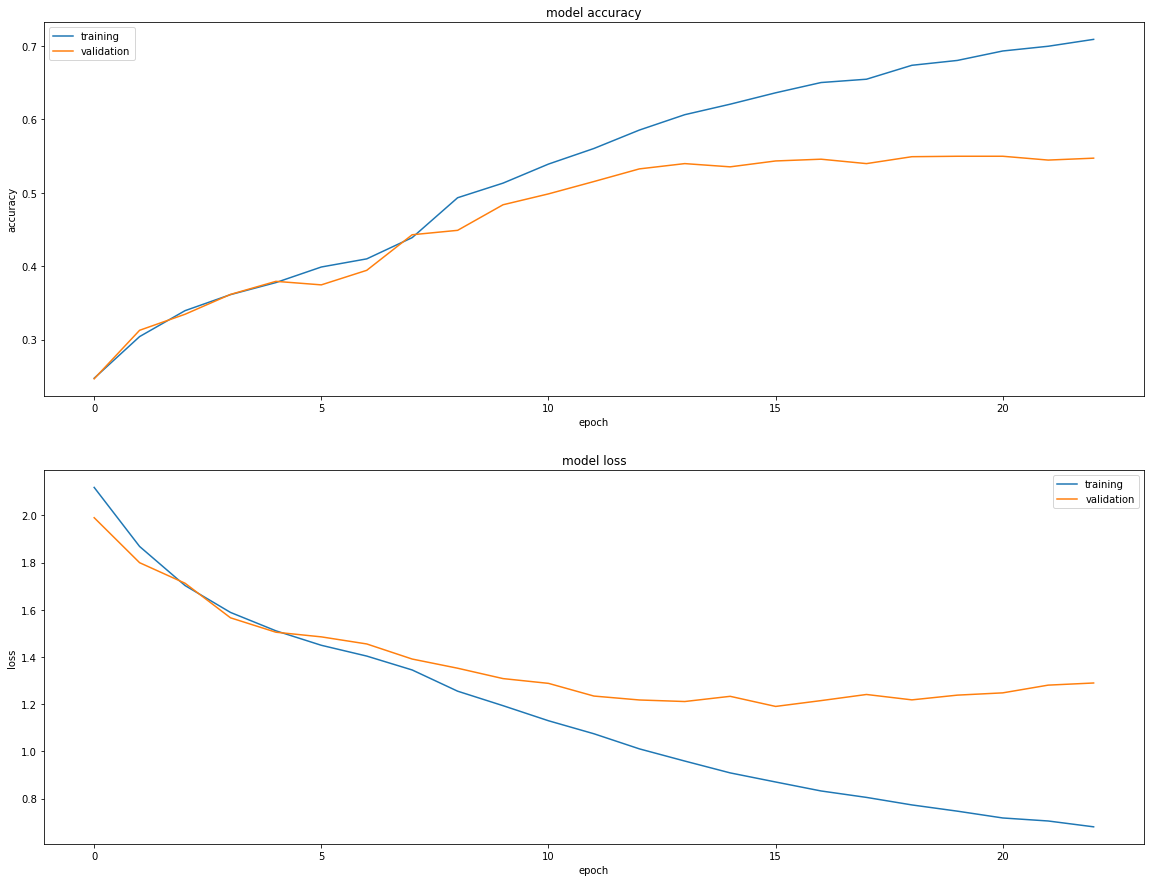

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine the precision, recall, F1-score, and confusion matrix.

In [34]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 8s 25ms/step


In [35]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.16      0.22      1000
           1       0.50      0.81      0.62      1000
           2       0.39      0.21      0.28      1000
           3       0.52      0.48      0.50      1000
           4       0.53      0.60      0.56      1000
           5       0.54      0.59      0.56      1000
           6       0.68      0.82      0.75      1000
           7       0.76      0.74      0.75      1000
           8       0.48      0.80      0.60      1000
           9       0.37      0.16      0.22      1000

    accuracy                           0.54     10000
   macro avg       0.52      0.54      0.51     10000
weighted avg       0.52      0.54      0.51     10000

Accuracy Score: 0.5376
Root Mean Square Error: 3.6756904113377122


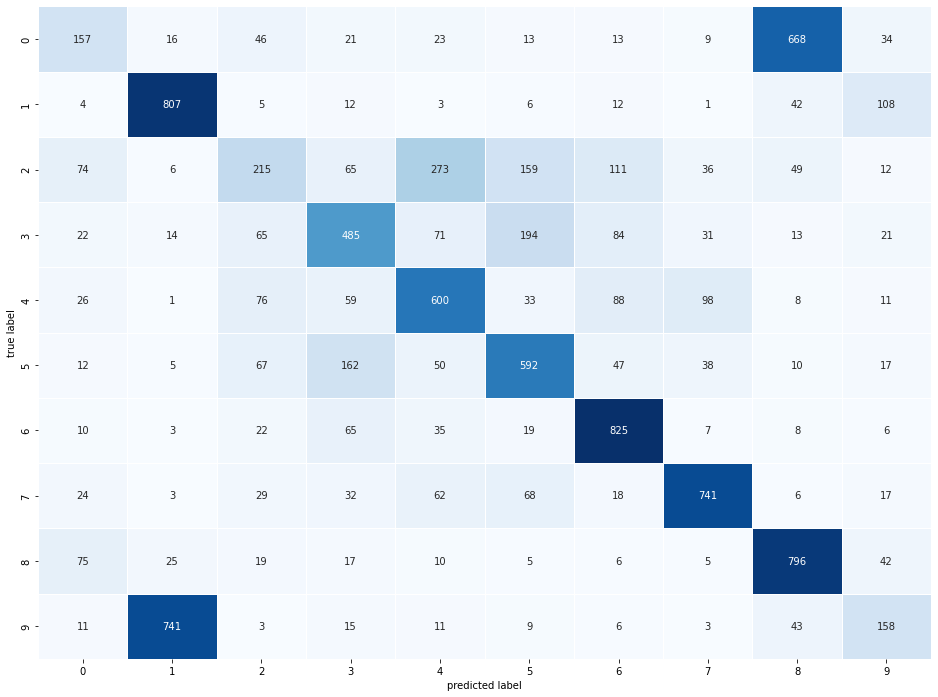

In [36]:
plot_confusion_matrix(y_test,pred1)

Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [37]:
model = tf.keras.models.load_model('CNN_model.h5')

In [38]:
preds = model.predict(x_test_norm)

313/313 [==============================] - 8s 25ms/step


In [39]:
preds.shape

(10000, 10)

Let's examine the predictions

In [40]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [41]:
df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,1.01%,0.62%,0.31%,91.63%,0.84%,1.28%,1.21%,1.20%,1.01%,0.88%
1,44.35%,0.19%,2.92%,0.19%,0.34%,0.04%,0.07%,0.06%,51.52%,0.32%
2,24.38%,15.62%,3.38%,1.22%,0.61%,0.38%,0.53%,0.51%,33.60%,19.78%
3,44.70%,0.19%,3.10%,0.20%,0.36%,0.04%,0.07%,0.06%,50.93%,0.33%
4,1.11%,0.73%,14.22%,3.46%,19.01%,1.03%,58.32%,0.73%,0.59%,0.79%
5,0.17%,0.27%,1.70%,0.76%,1.35%,0.20%,95.12%,0.14%,0.20%,0.09%
6,0.42%,50.90%,0.12%,0.26%,0.03%,0.13%,0.15%,0.14%,0.70%,47.16%
7,1.33%,0.72%,18.85%,4.55%,22.99%,1.69%,47.31%,1.04%,0.62%,0.90%
8,2.26%,0.79%,1.39%,71.84%,4.70%,3.47%,1.42%,11.34%,1.11%,1.68%
9,0.43%,50.83%,0.12%,0.26%,0.03%,0.13%,0.15%,0.14%,0.72%,47.19%


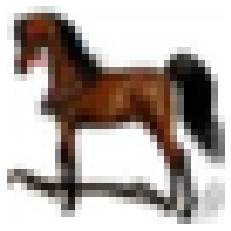

In [42]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [43]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [44]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 315ms/step


7

In [45]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

C:\Users\steve\AppData\Local\Temp\ipykernel_36656\4183080112.py:28: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


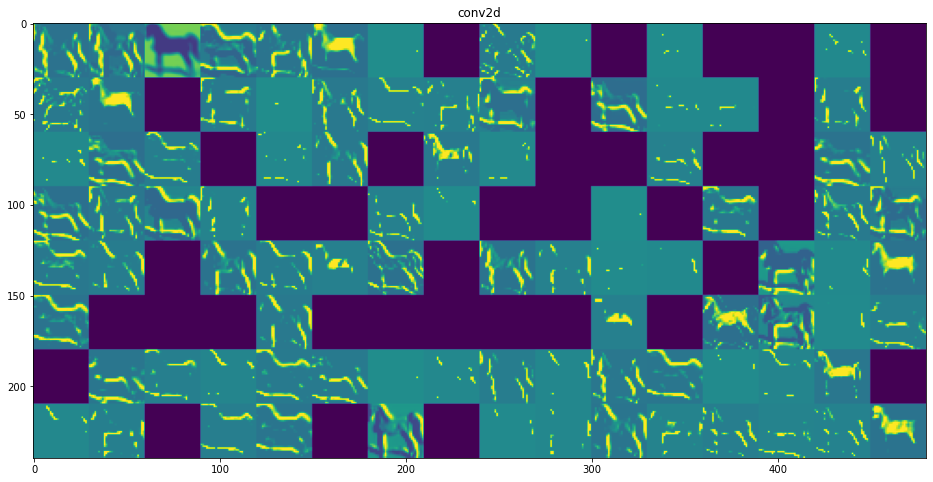

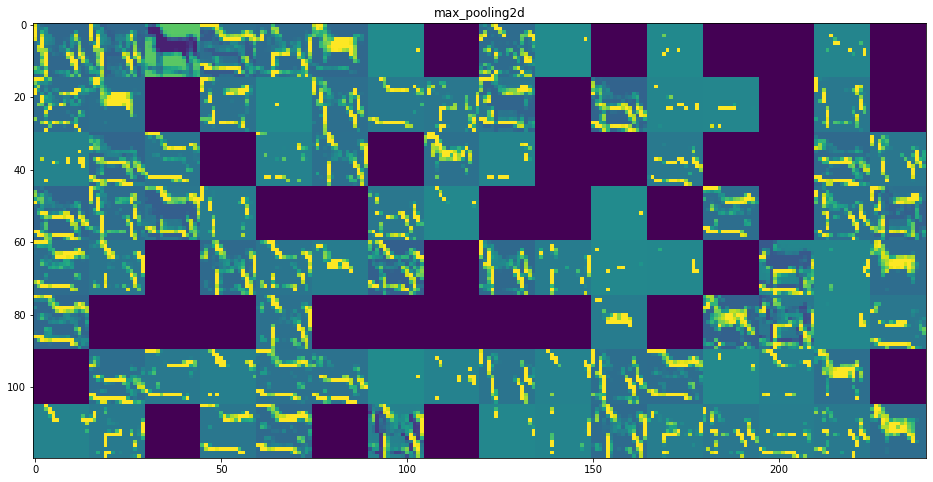

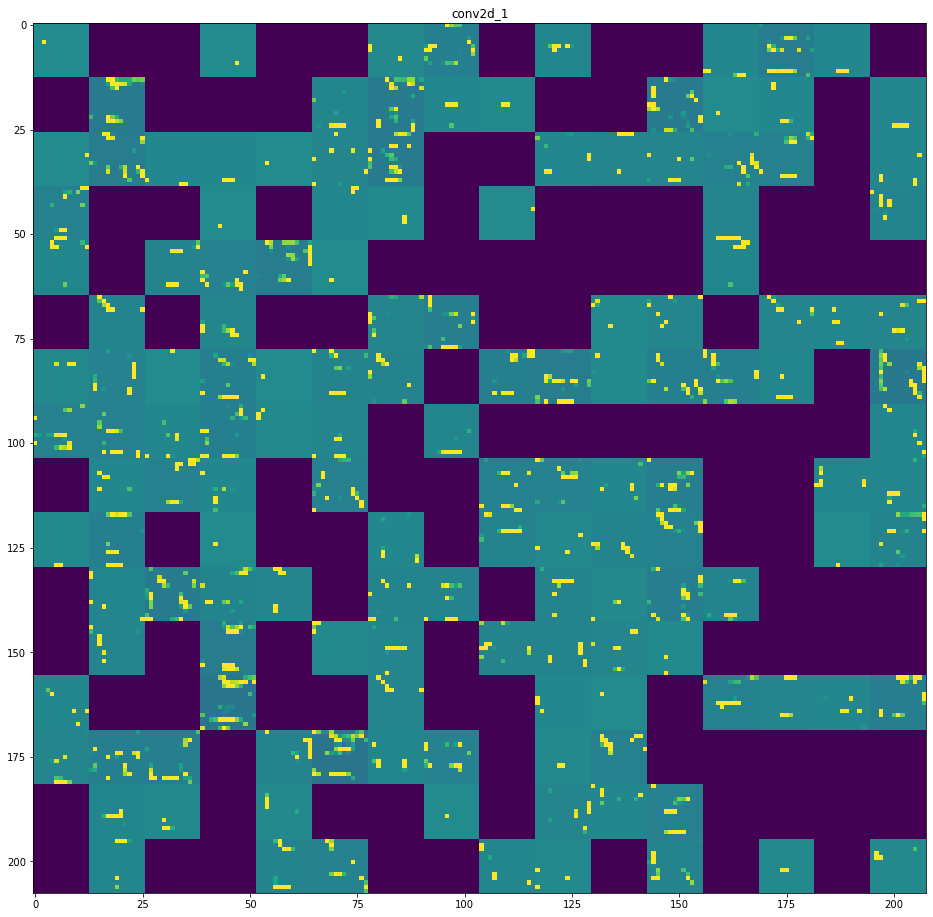

In [46]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

## 5) Model 4 - CNN with 3 Max Pooling / Hidden Layers and No Regularization Methods

### 5.1) Build The Model

We use a Sequential class defined in Keras to create our model. 

In [ ]:
k.clear_session()
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True)

Let's now compile and train the model.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

### 5.2) Evaluate Model Performance

In [ ]:
model = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

Let's examine the precision, recall, F1 score, and confusion matrix.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

In [ ]:
plot_confusion_matrix(y_test,pred1)

Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('CNN_model.h5')
preds = model.predict(x_test_norm)
preds.shape

Let's examine the predictions for the testing dataset.

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

layer_names

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

Image 0


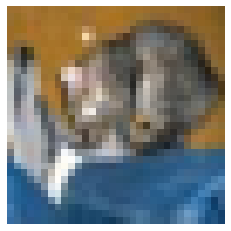

Image 1


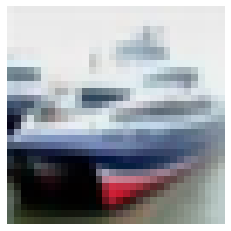

Image 2


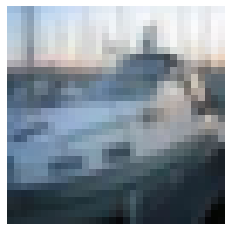

Image 3


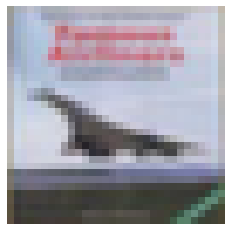

Image 4


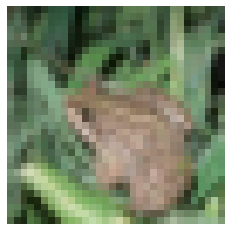

Image 5


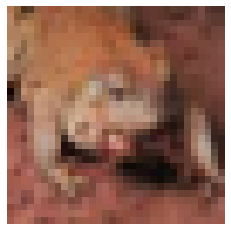

Image 6


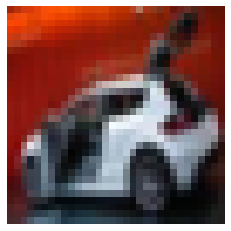

Image 7


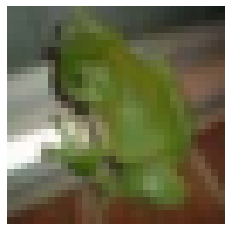

Image 8


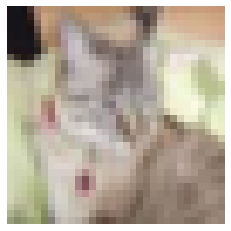

Image 9


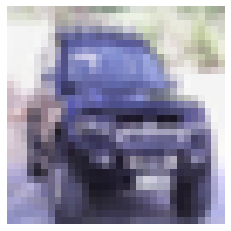

Image 10


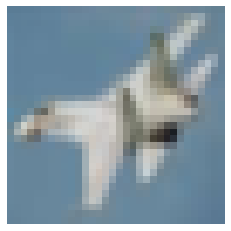

Image 11


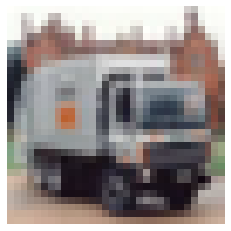

Image 12


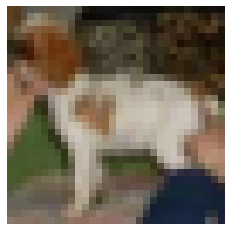

Image 13


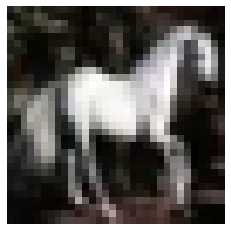

Image 14


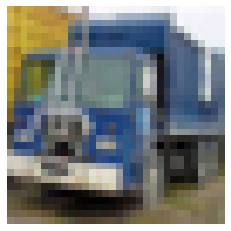

Image 15


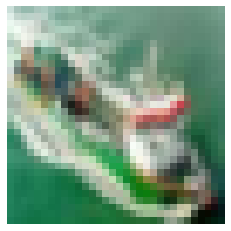

Image 16


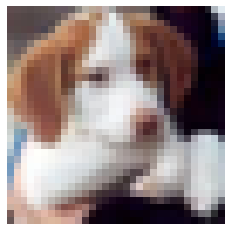

Image 17


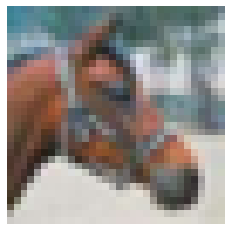

Image 18


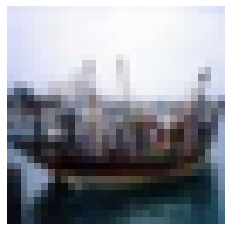

Image 19


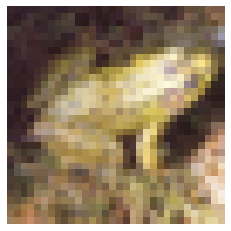

Image 20


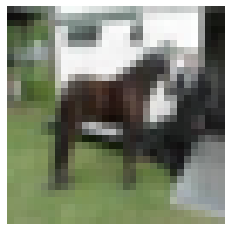

Image 21


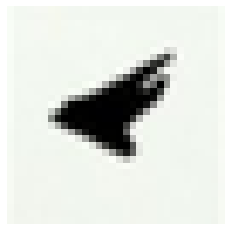

Image 22


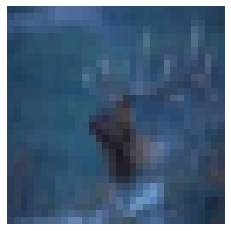

Image 23


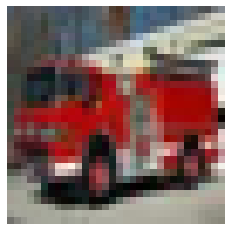

Image 24


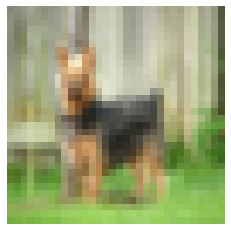

Image 25


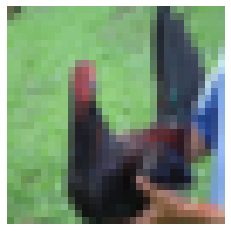

Image 26


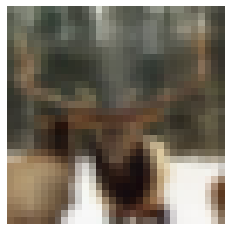

Image 27


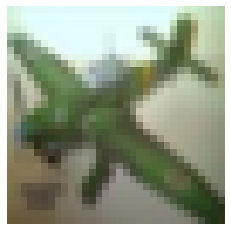

Image 28


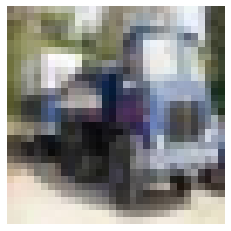

Image 29


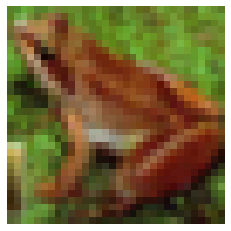

Image 30


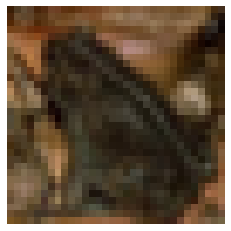

Image 31


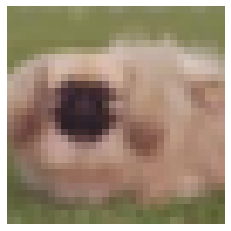

Image 32


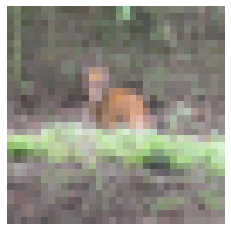

Image 33


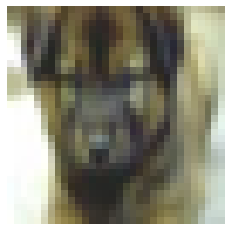

Image 34


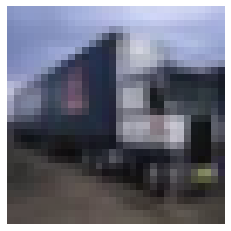

Image 35


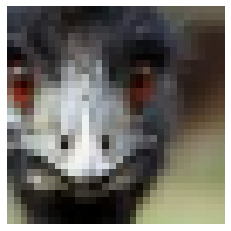

Image 36


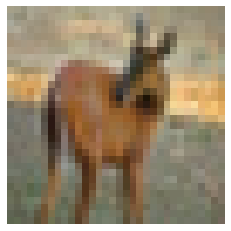

Image 37


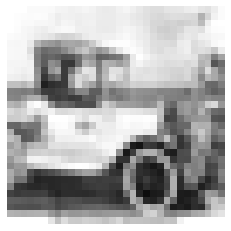

Image 38


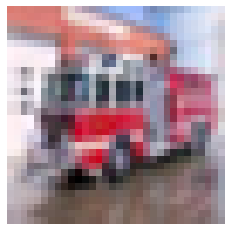

Image 39


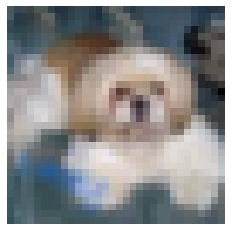

Image 40


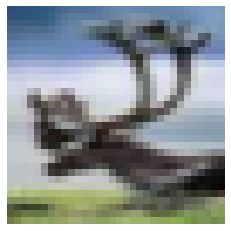

Image 41


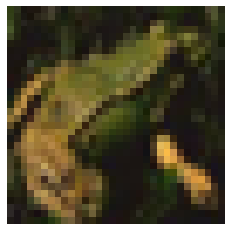

Image 42


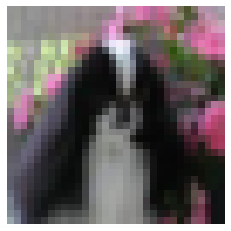

Image 43


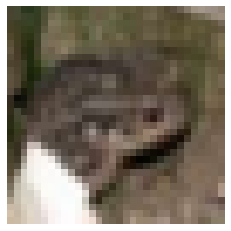

Image 44


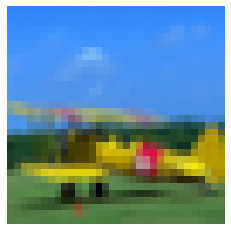

Image 45


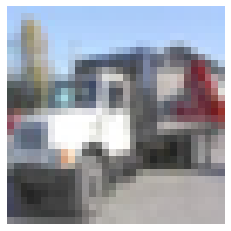

Image 46


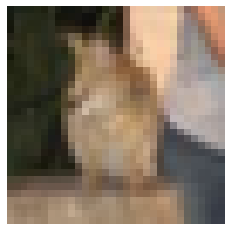

Image 47


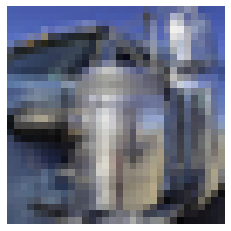

Image 48


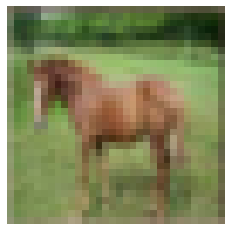

Image 49


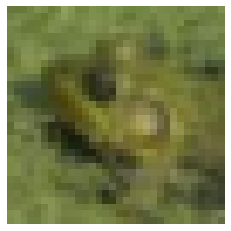

Image 50


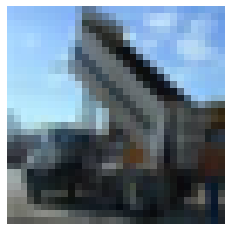

Image 51


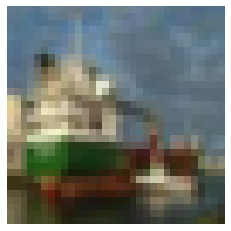

Image 52


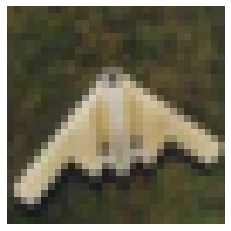

Image 53


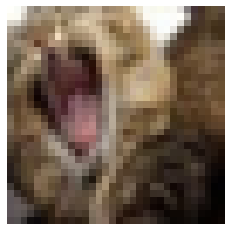

Image 54


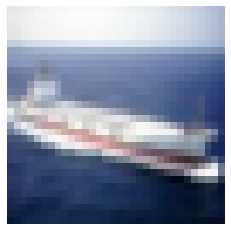

Image 55


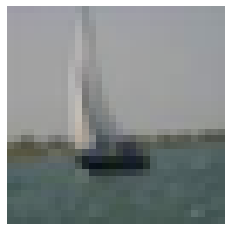

Image 56


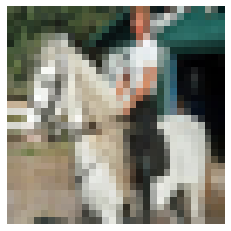

Image 57


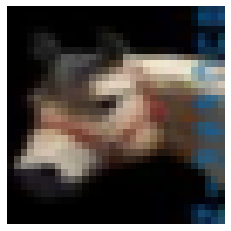

Image 58


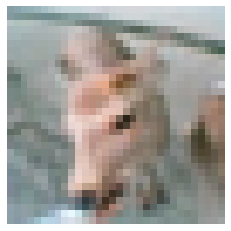

Image 59


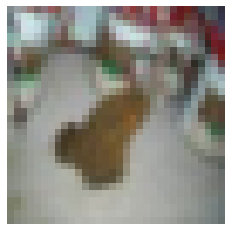

Image 60


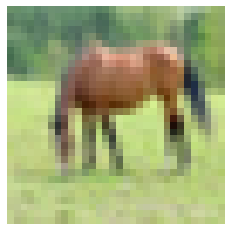

Image 61


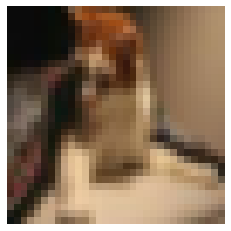

Image 62


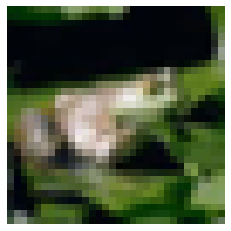

Image 63


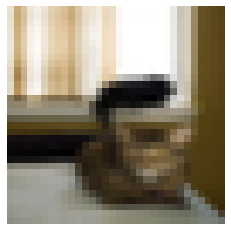

Image 64


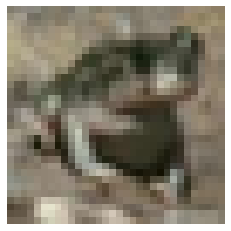

Image 65


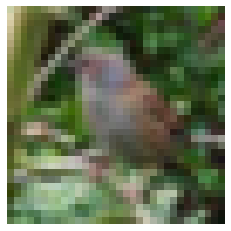

Image 66


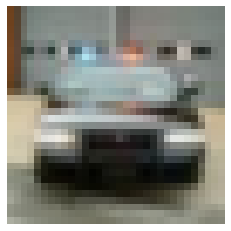

Image 67


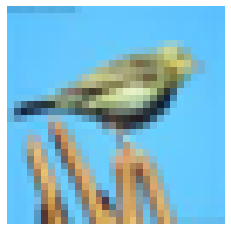

Image 68


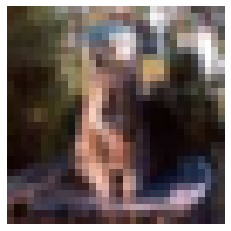

Image 69


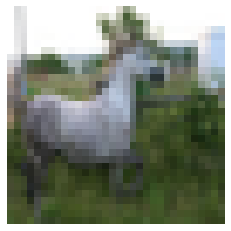

Image 70


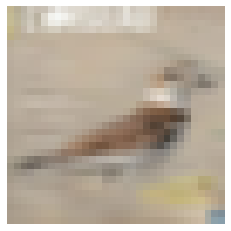

Image 71


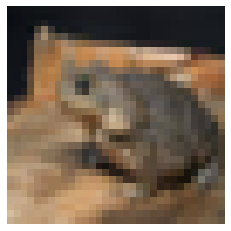

Image 72


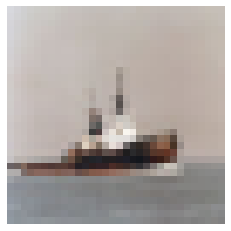

Image 73


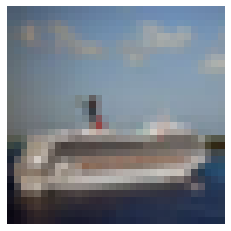

Image 74


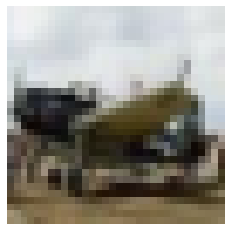

Image 75


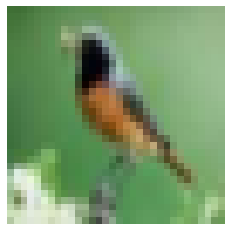

Image 76


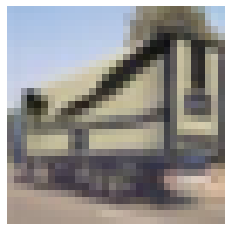

Image 77


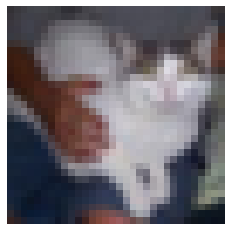

Image 78


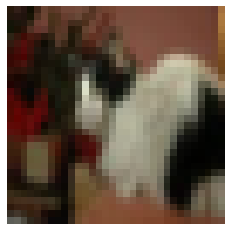

Image 79


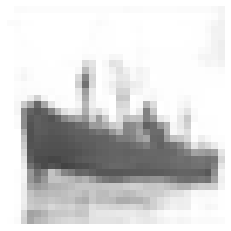

Image 80


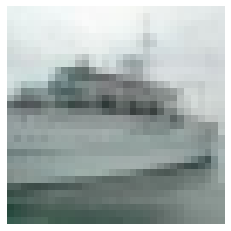

Image 81


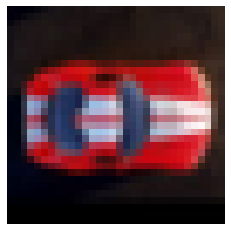

Image 82


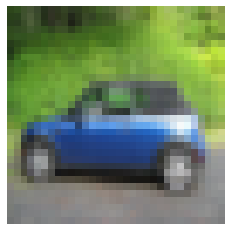

Image 83


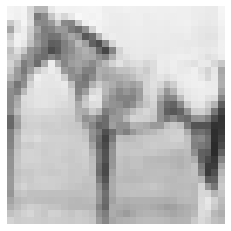

Image 84


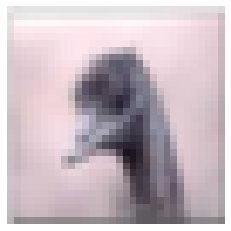

Image 85


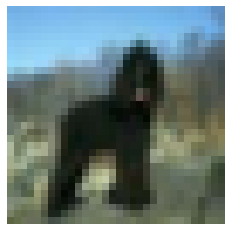

Image 86


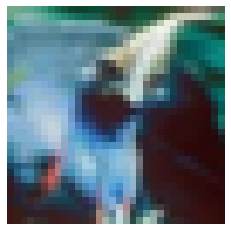

Image 87


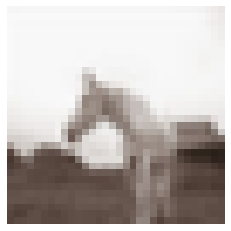

Image 88


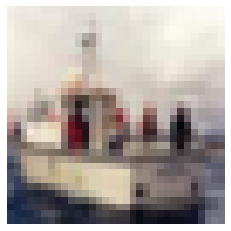

Image 89


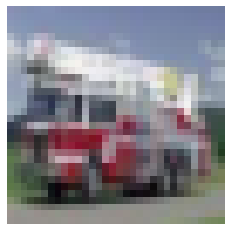

Image 90


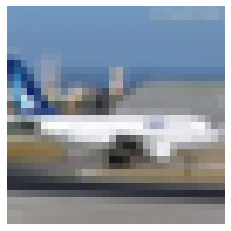

Image 91


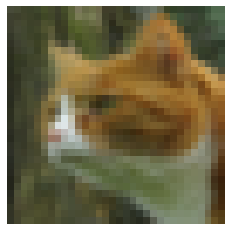

Image 92


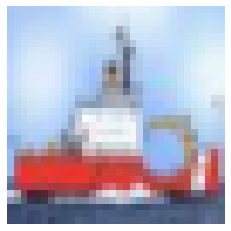

Image 93


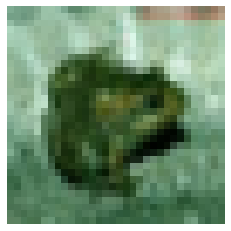

Image 94


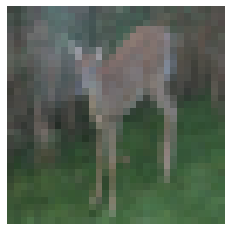

Image 95


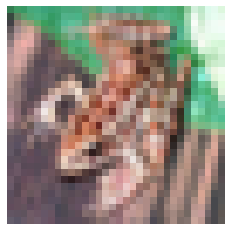

Image 96


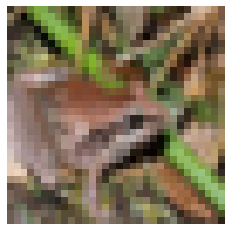

Image 97


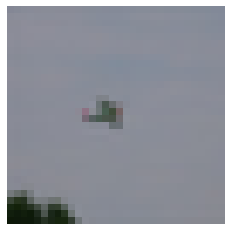

Image 98


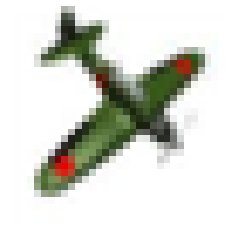

Image 99


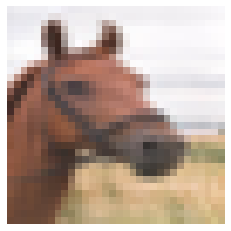

Image 100


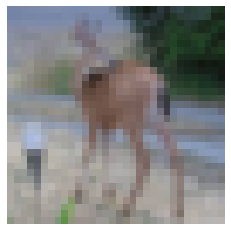

Image 101


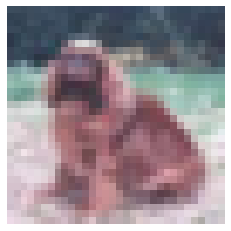

Image 102


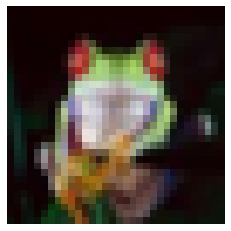

Image 103


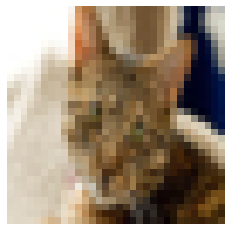

Image 104


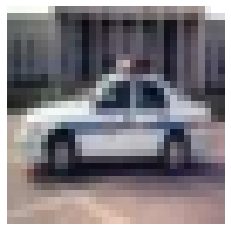

Image 105


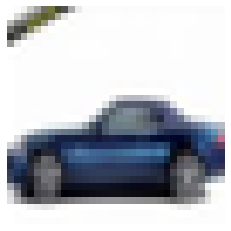

Image 106


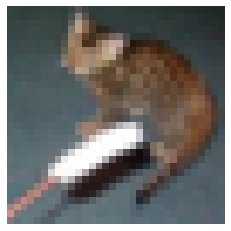

Image 107


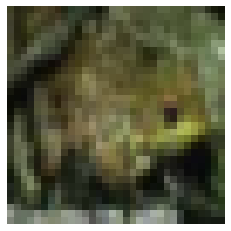

Image 108


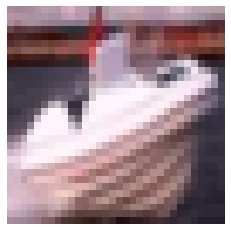

Image 109


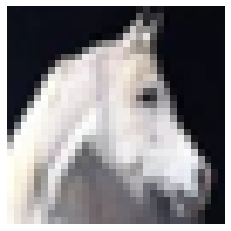

Image 110


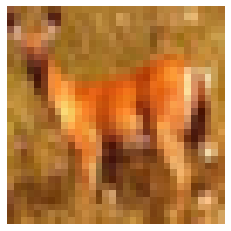

Image 111


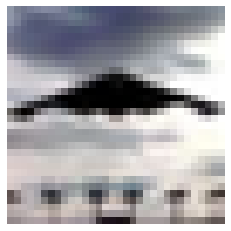

Image 112


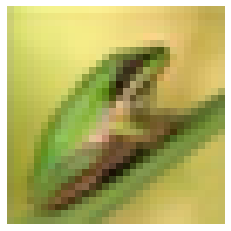

Image 113


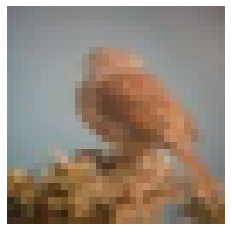

Image 114


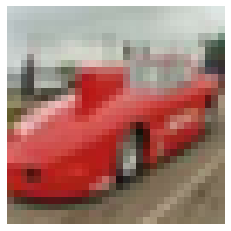

Image 115


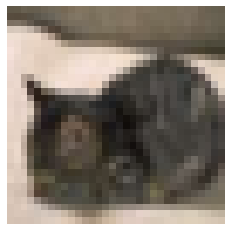

Image 116


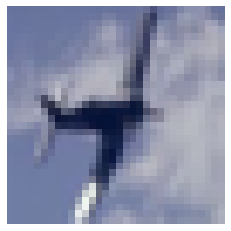

Image 117


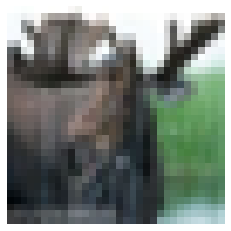

Image 118


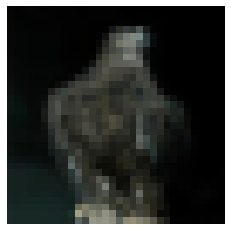

Image 119


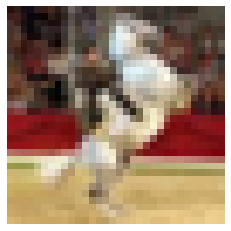

Image 120


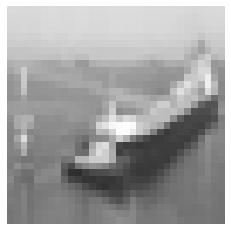

Image 121


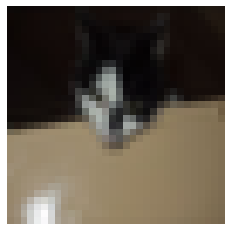

Image 122


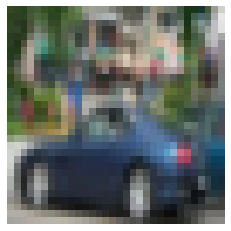

Image 123


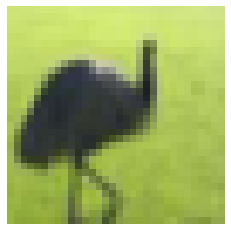

Image 124


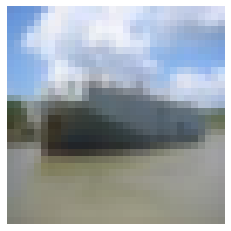

Image 125


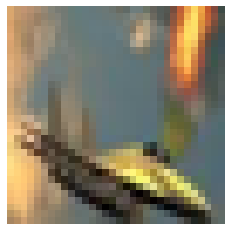

Image 126


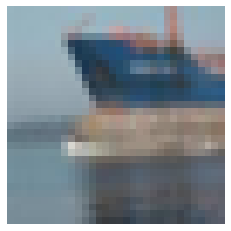

Image 127


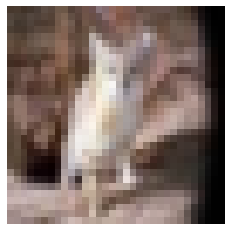

Image 128


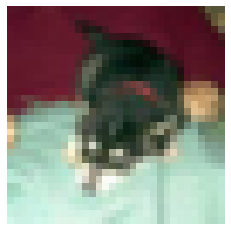

Image 129


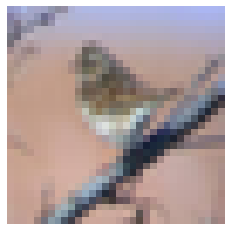

Image 130


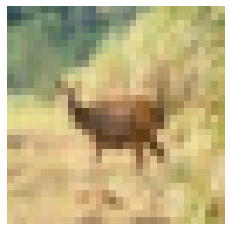

Image 131


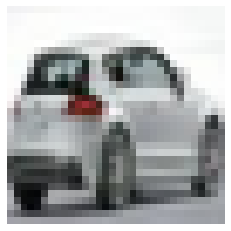

Image 132


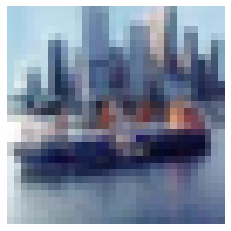

Image 133


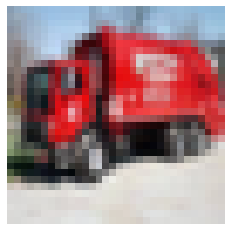

Image 134


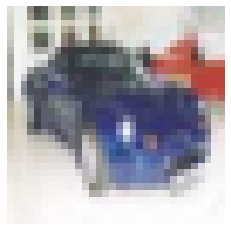

Image 135


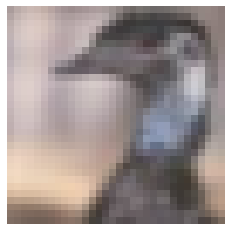

Image 136


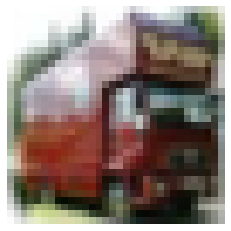

Image 137


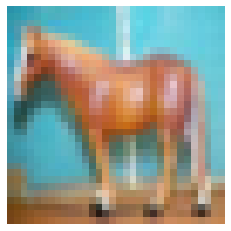

Image 138


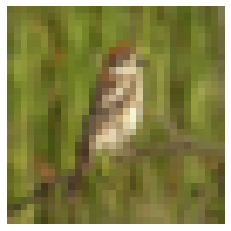

Image 139


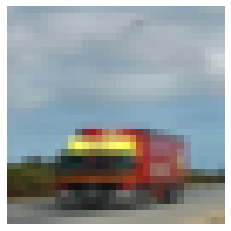

Image 140


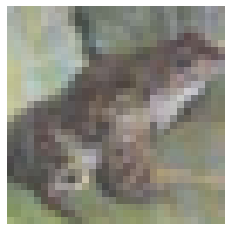

Image 141


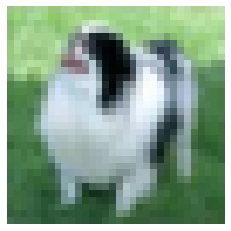

Image 142


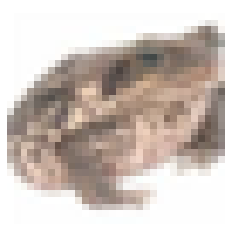

Image 143


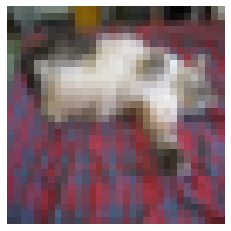

Image 144


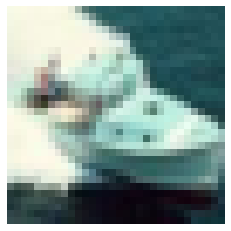

Image 145


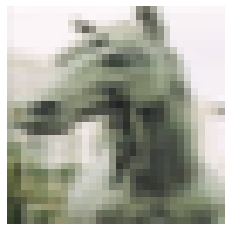

Image 146


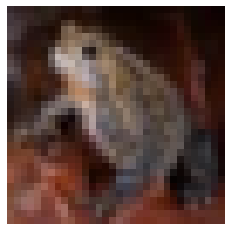

Image 147


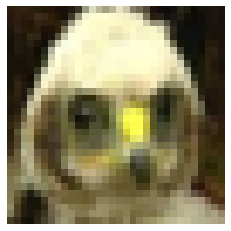

Image 148


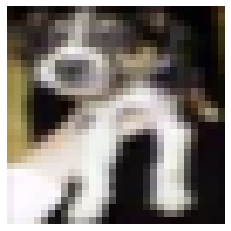

Image 149


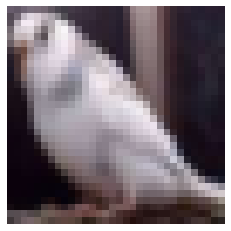

Image 150


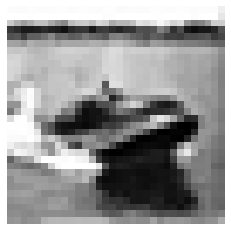

Image 151


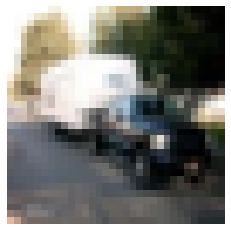

Image 152


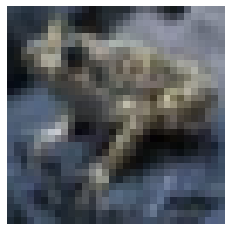

Image 153


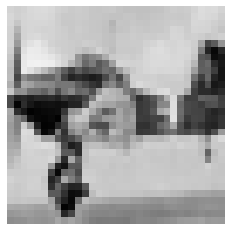

Image 154


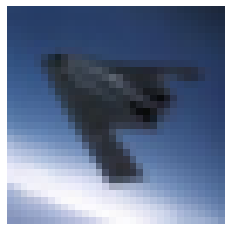

Image 155


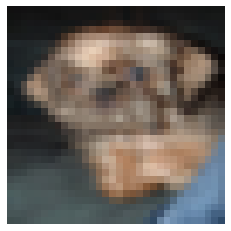

Image 156


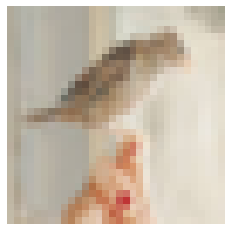

Image 157


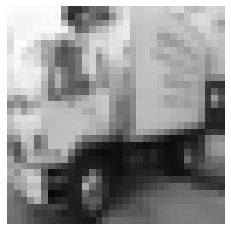

Image 158


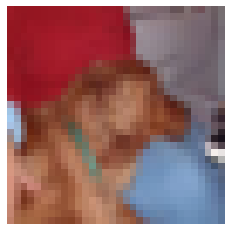

Image 159


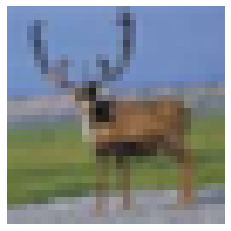

Image 160


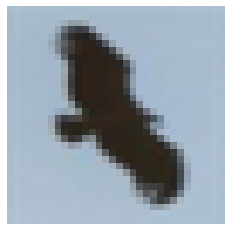

Image 161


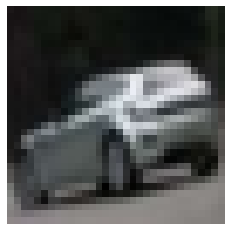

Image 162


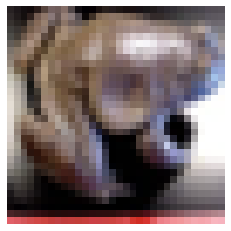

Image 163


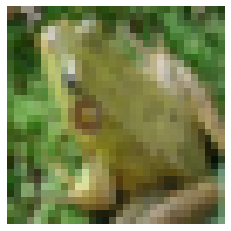

Image 164


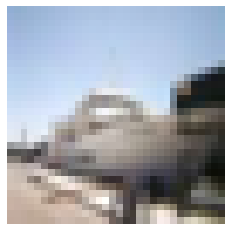

Image 165


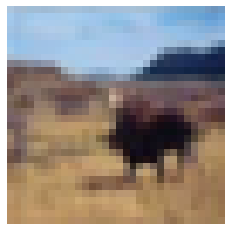

Image 166


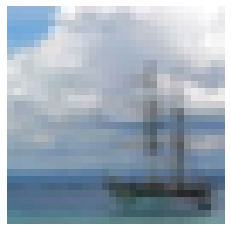

Image 167


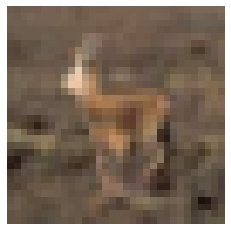

Image 168


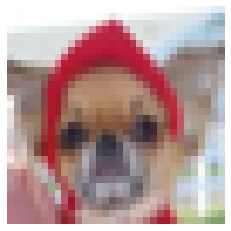

Image 169


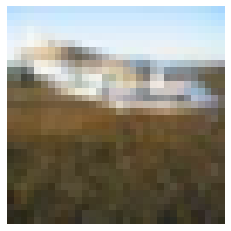

Image 170


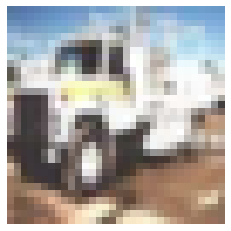

Image 171


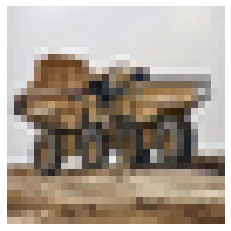

Image 172


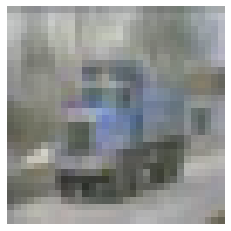

Image 173


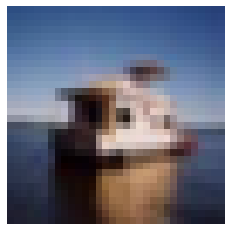

Image 174


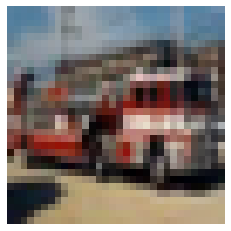

Image 175


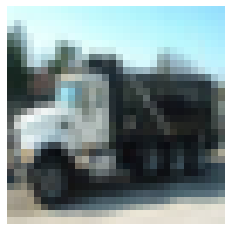

Image 176


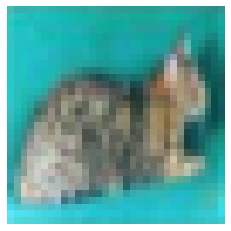

Image 177


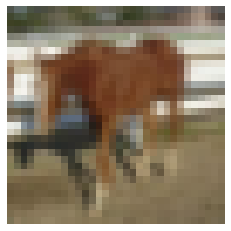

Image 178


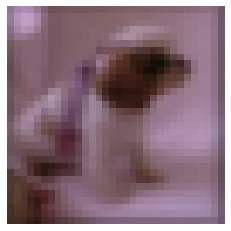

Image 179


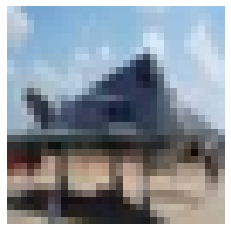

Image 180


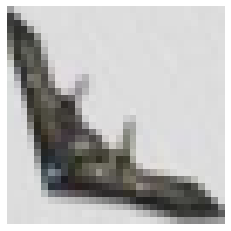

Image 181


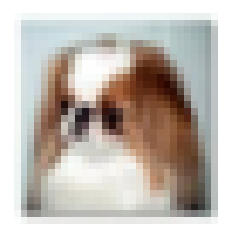

Image 182


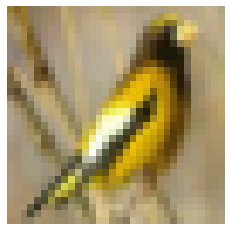

Image 183


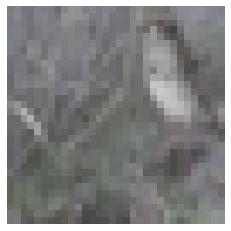

Image 184


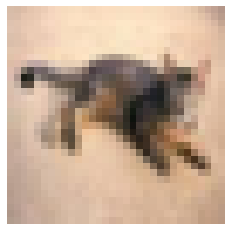

Image 185


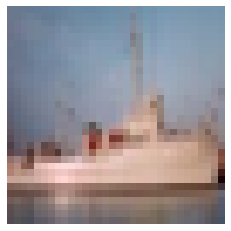

Image 186


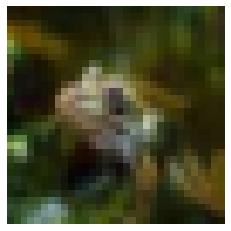

Image 187


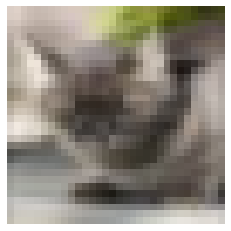

Image 188


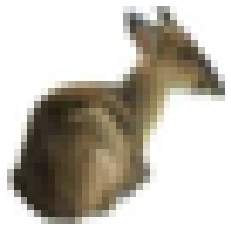

Image 189


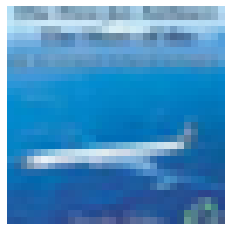

Image 190


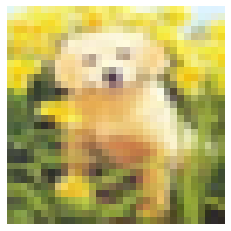

Image 191


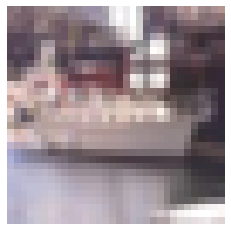

Image 192


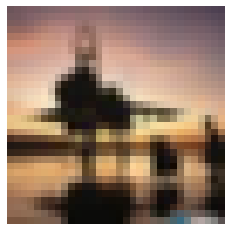

Image 193


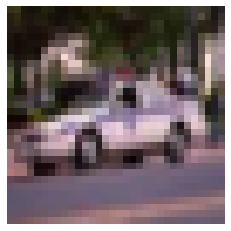

Image 194


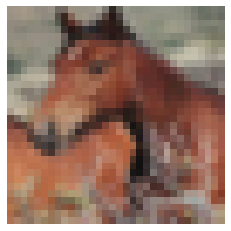

Image 195


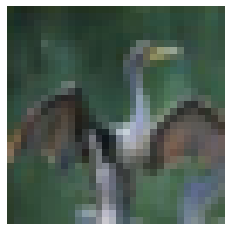

Image 196


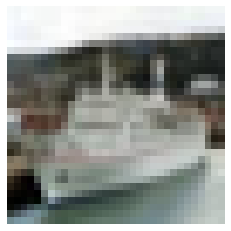

Image 197


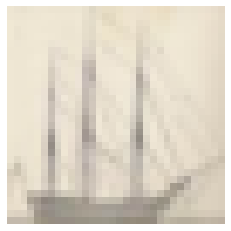

Image 198


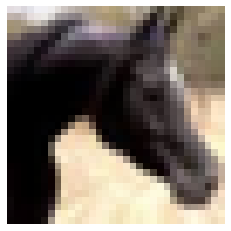

Image 199


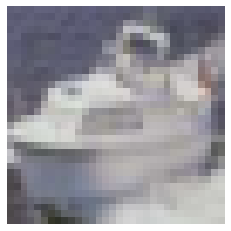